In [1]:
# Importing libraries
import pickle
import itertools
import string
import re
import numpy as np
import pandas as pd
import multiprocessing
from collections import Counter
from scipy.sparse import csr_matrix
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

### Load the preprocessed data and Doc2Vec model from the data_directory 

In [2]:
#!pip install testfixtures

In [3]:
data_directory = "Generated_Files/data_after_preprocessing.csv"

filename = 'Generated_Files/doc2vec_model.sav'
new_model = pickle.load(open(filename, 'rb'))

### We devide the data into 3 groups:
* Group 1: full data
* Group 2: data with four large categories which have more than 1000 companies each
* Group 3: seven categories of data, number of companies in each category is same but small

### In the function selectGroup, giving 1, 2 or 3 as input parameter to selet the relevant data for experiment

In [4]:
# read the data from directory, then select the group 
# of data we want to process.
def selectGroup(directory, group_nr):
    data = pd.read_csv(directory, sep='\t')
    if group_nr == 1:
        return data
    if group_nr == 2:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=1041,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=1041,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=1041,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=1041,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group])
        return df_clean.sample(frac=1)
    if group_nr == 3:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=219,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=219,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=219,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=219,replace=False)
        df_industry_goods=data[data['Category'] == 'INDUSTRIAL GOODS & MATERIALS GROUP'].sample(n=219,replace=False)
        df_consumer_goods=data[data['Category'] == 'CONSUMER GOODS GROUP'].sample(n=219,replace=False)
        df_energy=data[data['Category'] == 'ENERGY & UTILITIES GROUP'].sample(n=219,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group,df_industry_goods,df_consumer_goods,df_energy])
        return df_clean.sample(frac=1)

In [5]:
# Select and Split the data
data = selectGroup(data_directory, 1)
train, test = train_test_split(data, test_size=0.2, random_state=42)

### Define functions to calculate cosine similarity of two clusters of companies

In [6]:
# pick two categories and calculate the cosine similarity score
def pick_cluster(X, y_new, n):
    for index, label in enumerate(y_new):
        if label ==n: 
            cluster_data = np.vstack(cluster_data, X[index])
            
    return cluster_data

def average_similarity(cluster1, cluster2):
    sim = cosine_similarity(cluster1, cluster2)
    ave = sim.mean(1)
    cluster_similarity = ave.sum()/len(ave)
    return cluster_similarity

### Display the similarity between different business categories based on vectors generated from doc2vec

In [7]:
#Doc2Vec Similarity
#Generate tagged documents
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean']), tags=[r.Category]), axis=1)
cores = multiprocessing.cpu_count()

In [8]:
# Infer vectors from doc2vec model
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
y_train, X_train = get_vectors(new_model, train_tagged)
print("Infer vector done for train data")
y_test, X_test = get_vectors(new_model, test_tagged)

X = X_train + X_test
y = y_train + y_test
X = csr_matrix(pd.DataFrame(list(X)))
categories = ['BUSINESS & FINANCIAL SERVICES', 'CONSUMER GOODS GROUP', 'CONSUMER SERVICES GROUP', 'ENERGY & UTILITIES GROUP', 'HEALTHCARE GROUP', 'INDUSTRIAL GOODS & MATERIALS GROUP', 'INFORMATION TECHNOLOGY GROUP'] 
new_label = [0, 1, 2, 3, 4, 5, 6]
mydict=dict(zip(categories, new_label))
y_new = np.zeros(len(y))
for index, label in enumerate(y):
    y_new[index] = mydict[label]  
    
y_new = pd.DataFrame({"Category":list(y)})

Infer vector done for train data


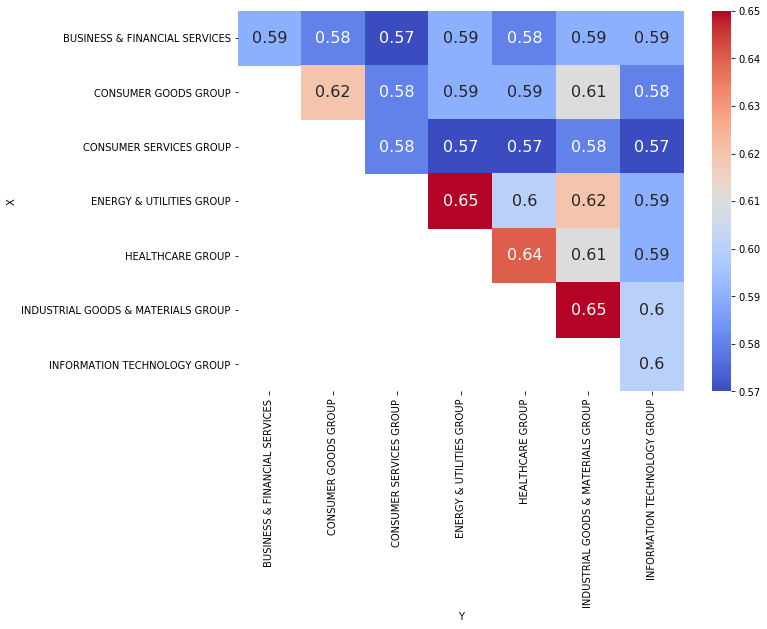

In [13]:
#Display the similarity matrix 
similarityArry=np.zeros([7,7])
categories = ['BUSINESS & FINANCIAL SERVICES', 'CONSUMER GOODS GROUP', 'CONSUMER SERVICES GROUP', 'ENERGY & UTILITIES GROUP', 'HEALTHCARE GROUP', 'INDUSTRIAL GOODS & MATERIALS GROUP', 'INFORMATION TECHNOLOGY GROUP'] 

for i in range(0,7,1):
    for j in range(0,7,1):
        indice1 = (y_new["Category"] == categories[i]).to_numpy().nonzero()[0]
        indice2 = (y_new["Category"] == categories[j]).to_numpy().nonzero()[0]
        cluster1 = X[indice1]
        cluster2 = X[indice2]
        similarityArry[i,j] =round(average_similarity(cluster1, cluster2),2)

array = similarityArry
y_true = ["BUSINESS & FINANCIAL SERVICES","CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP","ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP","INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
y_pred = ["BUSINESS & FINANCIAL SERVICES","CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP","ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP","INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
df_cm = pd.DataFrame(array, y_true, y_pred)
df_cm.index.name = 'X'
df_cm.columns.name = 'Y'
plt.figure(figsize = (10,7))

mask = np.tri(array.shape[0], k=-1)

ax=sn.heatmap(df_cm, mask=mask, cmap="coolwarm", annot=True,annot_kws={"size": 16})# font size
bottom, top=ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
ax.tick_params(labelsize=10)
plt.show()

### Display the similarity between different business categories based on vectors generated from TF-IDF

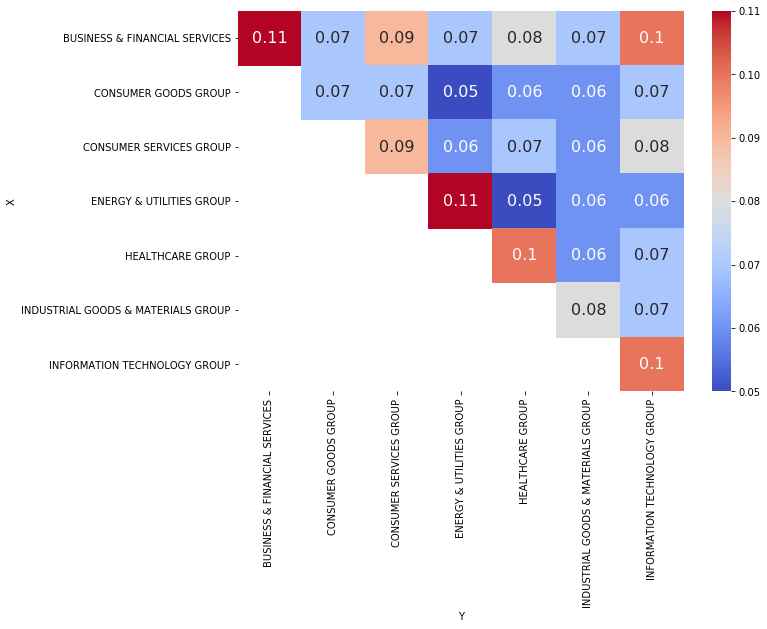

In [14]:
#TF-IDF Similarity
#Generate vectors from TF-IDF
feature_extraction = TfidfVectorizer( min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    #ngram_range=(1, 2),
    stop_words = 'english')
X_tfidf = feature_extraction.fit_transform(data['clean'].values)
y_tfidf = data['Category'].values

#Display the similarity matrix
similarityArry=np.zeros([7,7])
categories = ['BUSINESS & FINANCIAL SERVICES', 'CONSUMER GOODS GROUP', 'CONSUMER SERVICES GROUP', 'ENERGY & UTILITIES GROUP', 'HEALTHCARE GROUP', 'INDUSTRIAL GOODS & MATERIALS GROUP', 'INFORMATION TECHNOLOGY GROUP'] 

for i in range(0,7,1):
    for j in range(0,7,1):
        indice1 = (y_tfidf == categories[i]).nonzero()[0]
        indice2 = (y_tfidf == categories[j]).nonzero()[0]
        cluster1 = X_tfidf[indice1].todense()
        cluster2 = X_tfidf[indice2].todense()
        similarityArry[i,j] =round(average_similarity(cluster1, cluster2),2)

array = similarityArry
y_true = ["BUSINESS & FINANCIAL SERVICES","CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP","ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP","INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
y_pred = ["BUSINESS & FINANCIAL SERVICES","CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP","ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP","INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
df_cm = pd.DataFrame(array, y_true, y_pred)
df_cm.index.name = 'X'
df_cm.columns.name = 'Y'
plt.figure(figsize = (10,7))

mask = np.tri(array.shape[0], k=-1)

ax=sn.heatmap(df_cm, mask=mask, cmap="coolwarm", annot=True,annot_kws={"size": 16})# font size
bottom, top=ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
ax.tick_params(labelsize=10)
plt.show()